J'ai récemment participé à **un projet de création éditoriale** d'étudiants de la Licence professionnelle de journalisme de Lannion, spécialité web. Ils avaient choisi en thématique charnière **les mobilités**, ce qui nous a permis de traiter beaucoup de données, notamment issues du recensement de l'INSEE.

C'est une super occasion de revenir sur [le potentiel de Python en infographie statique](https://github.com/raphadasilva/blog_rdasilva/blob/master/visualisations/deces_covid_vizu_simples/Visualisation%20simples%20-%20Python%20panda%20matplotlib.ipynb), avec cette fois-ci des manipulations géographiques. Nous aboutirons avec nos propres données sur **un modèle de carte à symboles proportionnels** équivalent à ceci :

![Bubble map](bubble_map.jpg)

Trêve de préambules, et importons les modules utiles pour ce tutoriel :

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from shapely.geometry import Point

C:\Users\raphi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\geopandas\_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.0-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


# Préparation du fond de carte

Nous allons d'abord travailler sur le fond de carte. Il se basera sur deux jeux de données :

* [les contours départementaux](https://www.data.gouv.fr/fr/datasets/contours-des-departements-francais-issus-d-openstreetmap/), fournis par OpenStreetMap
* [les tracés des rails](https://data.sncf.com/explore/dataset/formes-des-lignes-du-rfn/information/), délivrés par la SNCF

Chaque jeu va être chargé en tant que [GeoDataFrame](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.html), le format tabulaire de référence dans la bibliothèque geopandas. Exemple avec les départements :

In [2]:
dep_FR=gpd.read_file("https://www.data.gouv.fr/fr/datasets/r/eb36371a-761d-44a8-93ec-3d728bec17ce")
dep_FR.tail()

,code_insee,nom,nuts3,wikipedia,surf_km2,geometry
97,56,Morbihan,FR524,fr:Morbihan,6870.0,"MULTIPOLYGON (((-3.73508 48.11140, -3.73507 48..."
98,25,Doubs,FR431,fr:Doubs (département),5256.0,"POLYGON ((5.69876 47.26464, 5.69877 47.26481, ..."
99,39,Jura,FR432,fr:Jura (département),5049.0,"MULTIPOLYGON (((5.25202 46.94451, 5.25208 46.9..."
100,07,Ardèche,FR712,fr:Ardèche (département),5566.0,"POLYGON ((3.86110 44.71118, 3.86110 44.71151, ..."
101,30,Gard,FR812,fr:Gard,5875.0,"POLYGON ((3.26190 44.09335, 3.26221 44.09389, ..."


102 départements et six colonnes en tout, et côté rails :

In [3]:
rails_FR=gpd.read_file("https://data.sncf.com/explore/dataset/formes-des-lignes-du-rfn/download/?format=shp&timezone=Europe/Berlin&lang=fr")
rails_FR.tail()

,code_ligne,rg_troncon,pk_debut_r,pk_fin_r,libelle,mnemo,geometry
1828,664000,1.0,275+413,308+499,Neutralisée,NEUT,"LINESTRING (-0.60404 42.99382, -0.60424 42.992..."
1829,081311,1.0,000+000,001+131,Exploitée,EXPLOITE,"LINESTRING (4.05650 49.27335, 4.05588 49.27361..."
1830,460000,1.0,359+810,364+442,Fermée,FERME,"LINESTRING (-1.41797 47.70066, -1.41906 47.699..."
1831,748000,1.0,118+129,140+550,Exploitée,EXPLOITE,"LINESTRING (2.74434 48.00345, 2.74567 48.00029..."
1832,805000,1.0,736+249,755+250,Neutralisée,NEUT,"LINESTRING (4.12259 44.27613, 4.12259 44.27477..."


Un souci récurrent lors de la visualition de données géographiques peut intervenir **lorsque les projections cartographiques sont différentes**. Sans rentrer dans le détail, une projection est la méthode avec laquelle **on passe d'un volume comme notre Terre à une représentation sur un espace à deux dimensions comme un plan**.

**Aucune projection n'est parfaite** (la démonstration mathématique en a été faite), et elle est surtout affaire de compromis. Vérifions en attendant celle appliquée aux GeoDataFrames dep_FR et rails_FR :

In [4]:
# penchons-nous sur les proj
print(dep_FR.crs)
print(rails_FR.crs)

epsg:4326
epsg:4326


ESPG:4326 correspond à la mal-aimée Mercator, mais qui a été diablement utile aux premiers navigateurs pour ne pas se tromper dans leur trajectoire à partir de compas. Dans notre cas, **partons sur la projection franco-française Lambert-93**. Nous pouvons convertir très facilement les GDF comme ceci :

In [5]:
dep_FR=dep_FR.to_crs(2154)
rails_FR=rails_FR.to_crs(2154)
print(dep_FR.crs)
print(rails_FR.crs)

epsg:2154
epsg:2154


Cette conversion entérinée, nous allons passer à une première visualisation des départements grâce au module matplotlib :

<AxesSubplot:>

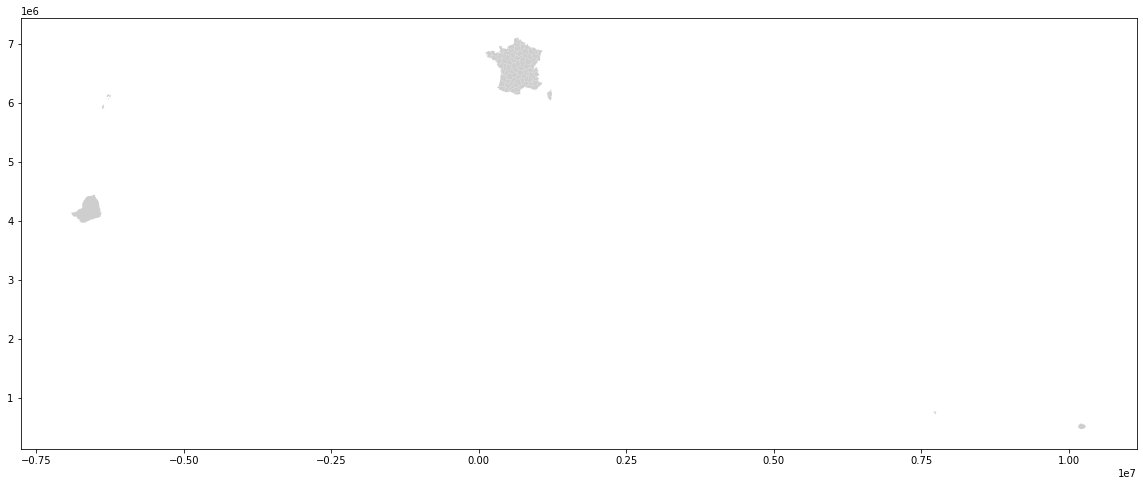

In [6]:
fig, ax = plt.subplots(figsize=(20,10))
dep_FR.plot(ax=ax, color = "#cecece", linewidth=.5)

L'ensemble des départements français ne permet pas de distinguer la Bretagne à sa juste valeur. Parons à cela **en modifiant les seuils des axes horizontaux et verticaux** à partir des valeurs affichées précédemment. Cela demande quelques essais, mais voici une manip' convenable :

(50000.0, 430000.0)

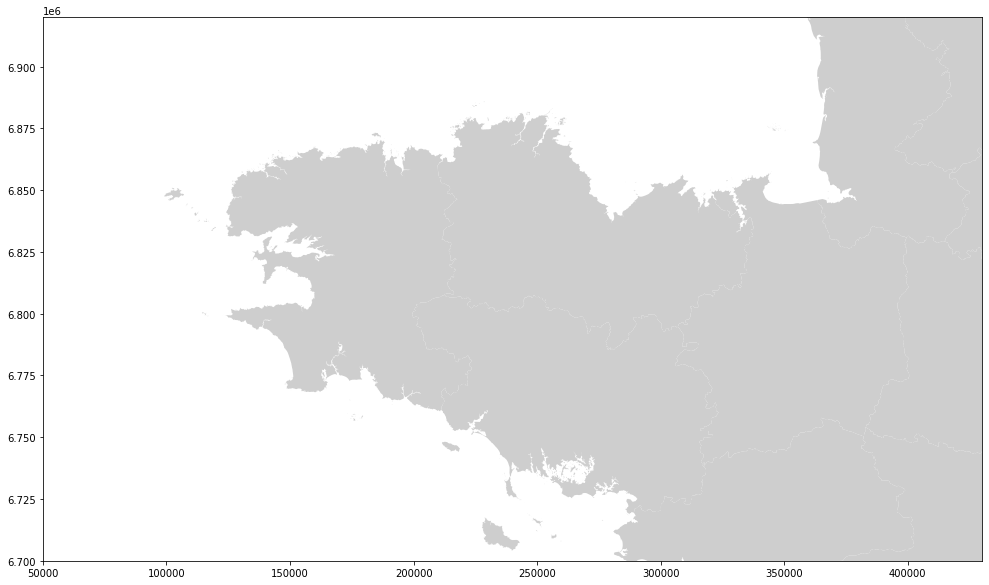

In [7]:
fig, ax = plt.subplots(figsize=(20,10))
dep_FR.plot(ax=ax, color="#cecece", linewidth=.7)
ax.set_ylim(6700000,6920000)
ax.set_xlim(50000,430000)

Affichons rapidement les trois premiers codes INSEE de dep_FR :

In [8]:
dep_FR.iloc[:3]["code_insee"]

0    974
1     11
2     43
Name: code_insee, dtype: object

Un code a priori chiffré, mais que l'on va convertir en chaînes de caractère. Cela va nous permettre **d'utiliser une liste de chaînes de caractères** (avec les départements bretons) afin de filtrer la GDF.

Pour rappel, un filtre de DF/GDF se paramètre très facilement sous la forme *DF\[DF\[condition(s)\]\]*. Le résultat de ce filtre va être enregistré dans une nouvelle variable :

In [9]:
bzh=["22","29","35","56"]
dep_FR["code_insee"]=dep_FR["code_insee"].astype(str)
dep_bretagne=dep_FR[dep_FR["code_insee"].isin(bzh)]
dep_bretagne["nom"]

50      Côtes-d'Armor
53    Ille-et-Vilaine
76          Finistère
97           Morbihan
Name: nom, dtype: object

Quatre noms de départements uniques, a priori la manip a fonctionné. On va également modifier dep_FR pour **soustraire les départements bretons**. La notation est toute simple, il suffit d'ajouter un ~ devant la précédente condition :

In [10]:
dep_FR=dep_FR[~dep_FR["code_insee"].isin(bzh)]
print(len(dep_FR))
print(len(dep_bretagne))

98
4


98 départements d'un côté, quatre de l'autre, cela fait bien 102 en tout. Pourquoi cette distinction ? Tout simplement pour **appliquer un style différent à chaque GDF** comme un calque à part.

Côté couleurs, j'ai utilisé [Google Art Palette](https://artsexperiments.withgoogle.com/artpalette/) afin de passer de cette photo de la plage armoricaine...

![Plage armoricaine](bzh.jpg)

...à cette palette de codes hexadécimaux :

![Palette carte](google_palette.jpg)

Nous allons impliquer deux couleurs de cette palette sur le fond de carte et les départements bretons. Quant à l'autre calque, nous allons l'éclaircir :

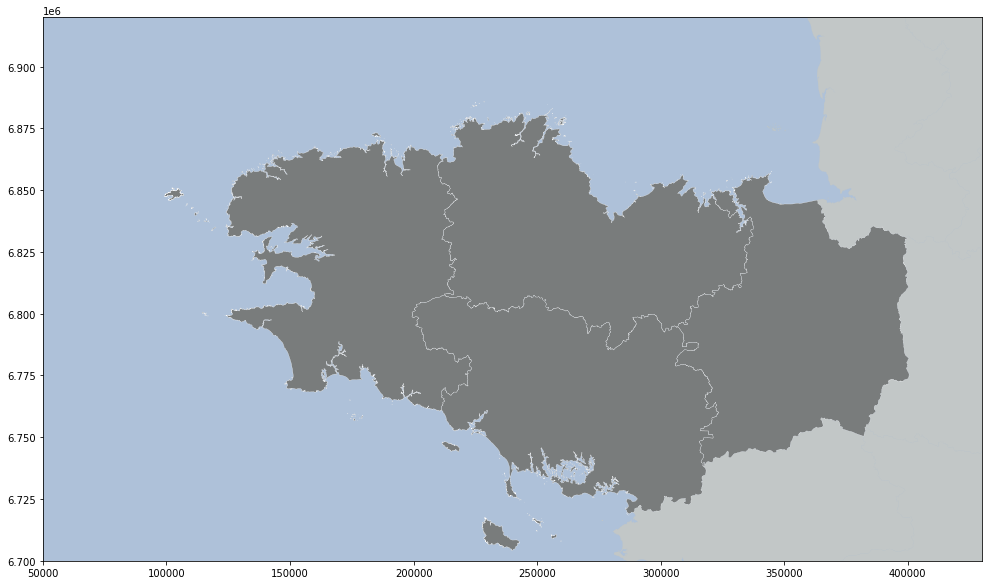

In [11]:
fig, ax = plt.subplots(figsize=(20,10))
ax.set_ylim(6700000,6920000)
ax.set_xlim(50000,430000)
ax.set_facecolor("#aec1d9")
dep_FR.plot(ax=ax, color="#c2c7c7", linewidth=.2,edgecolor="#c2c7c7")
dep_bretagne.plot(ax=ax, color="#797c7c", linewidth=.25,edgecolor="#fff");

Continuons sur cette lancée **en ajoutant le calque des rails** :

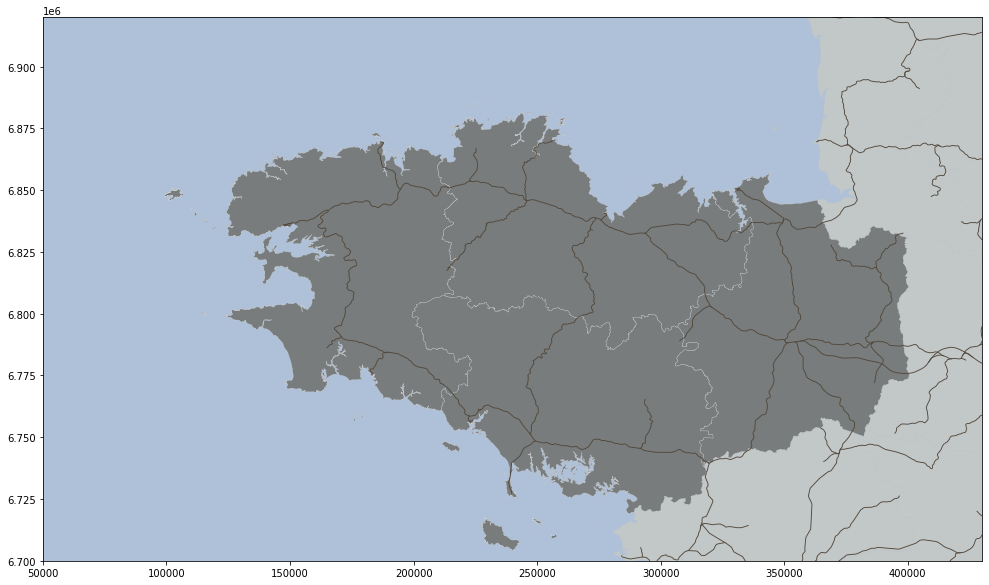

In [12]:
fig, ax = plt.subplots(figsize=(20,10))
ax.set_ylim(6700000,6920000)
ax.set_xlim(50000,430000)
ax.set_facecolor("#aec1d9")
dep_FR.plot(ax=ax, color="#c2c7c7", linewidth=.2,edgecolor="#c2c7c7")
dep_bretagne.plot(ax=ax, color="#797c7c", linewidth=.25,edgecolor="#d6d6d6")
rails_FR.plot(ax=ax, color="#52483c", linewidth=.9,edgecolor="#52483c");

Ce serait encore mieux si nous pouvions, sur le modèle des départements, **éclaircir les voies ferrées extérieures à la Bretagne**. La sélection risque d'être plus ardue à base de filtre, et une alternative assez simple à mettre en oeuvre consiste à fusionner les départements bretons dans un calque tampon... :

C:\Users\raphi\AppData\Local\Temp/ipykernel_11116/7388898.py:2: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  bretagne=dep_bretagne.dissolve().explode()


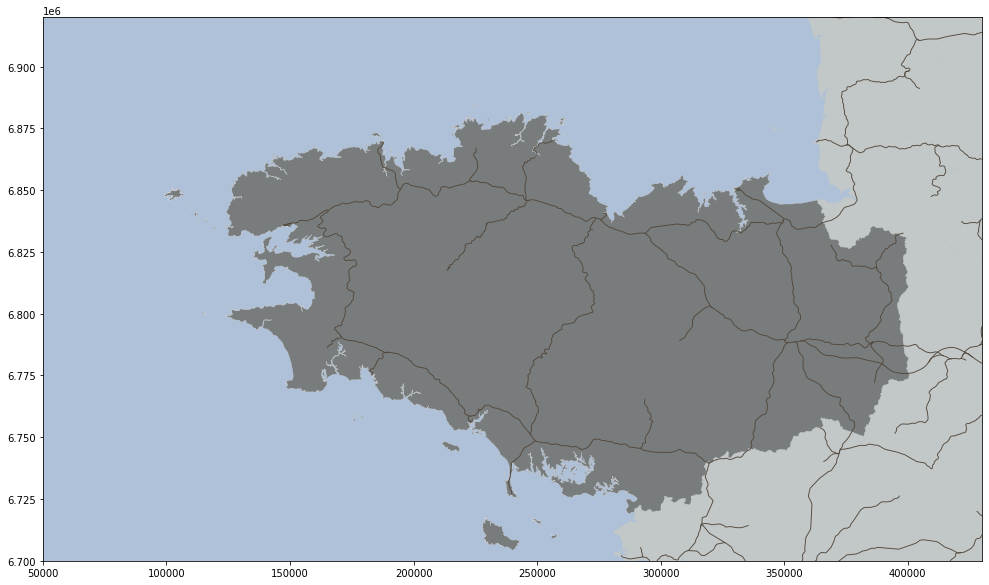

In [13]:
bretagne=dep_bretagne.copy()
bretagne=dep_bretagne.dissolve().explode()

fig, ax = plt.subplots(figsize=(20,10))
ax.set_ylim(6700000,6920000)
ax.set_xlim(50000,430000)
ax.set_facecolor("#aec1d9")
dep_FR.plot(ax=ax, color="#c2c7c7", linewidth=.2,edgecolor="#c2c7c7")
bretagne.plot(ax=ax, color="#797c7c", linewidth=.25,edgecolor="#d6d6d6")
rails_FR.plot(ax=ax, color="#52483c", linewidth=.9,edgecolor="#52483c");

...puis à utiliser [la fonction overlay](https://geopandas.org/en/stable/docs/reference/api/geopandas.overlay.html) de geopandas pour retenir les rails inclus dans la Bretagne et ceux hors de celle-ci.

Pareil que pour les départements : on crée une GDF par calque, **en copiant par précaution rails_FR** afin de la réserver en cas de fausse manip'.

Et une fois que ces calques sont créés, on les ajoute à la visualisation :

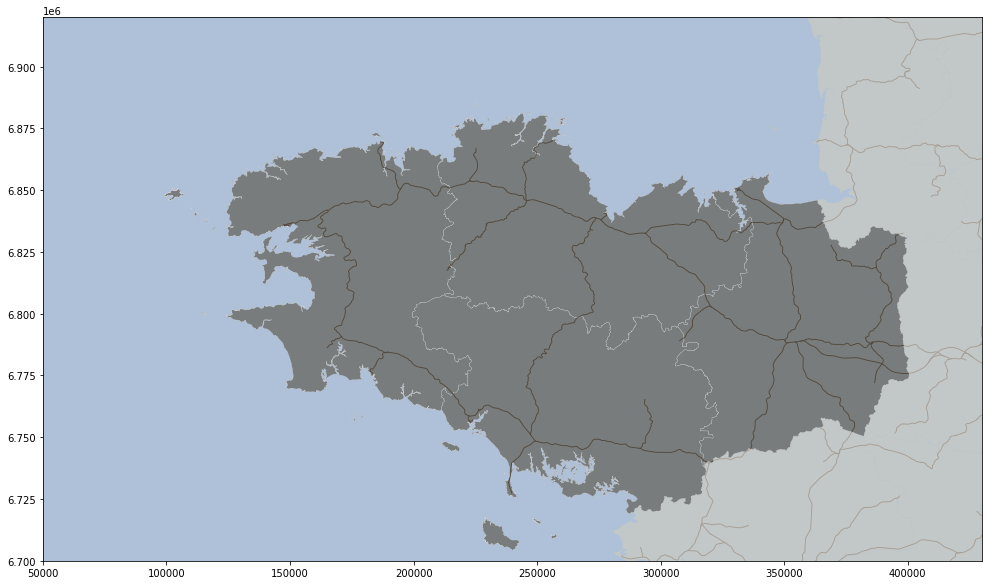

In [14]:
rails_bretagne=rails_FR.copy()
rails_hbretagne=rails_FR.copy()
rails_bretagne=gpd.overlay(rails_bretagne, bretagne, how='intersection')
rails_hbretagne=gpd.overlay(rails_hbretagne, bretagne, how='difference')

fig, ax = plt.subplots(figsize=(20,10))
ax.set_ylim(6700000,6920000)
ax.set_xlim(50000,430000)
ax.set_facecolor("#aec1d9")
dep_FR.plot(ax=ax, color="#c2c7c7", linewidth=.2,edgecolor="#c2c7c7")
rails_hbretagne.plot(ax=ax, color="#a69e94", linewidth=.9,edgecolor="#a69e94")
dep_bretagne.plot(ax=ax, color="#797c7c", linewidth=.25,edgecolor="#d6d6d6")
rails_bretagne.plot(ax=ax, color="#52483c", linewidth=.9,edgecolor="#52483c");

Ce fond de carte est plutôt correct, on peut passer à la suite !

# Ajout de données chiffrées

Nous allons passer au traitement très basique de données sur les fréquentations de différentes gares. D'abord, [lisons le fichier fourni par la SNCF](https://ressources.data.sncf.com/explore/dataset/frequentation-gares/) dans une nouvelle DataFrame :

In [15]:
frequentation=pd.read_csv("https://ressources.data.sncf.com/explore/dataset/frequentation-gares/download/?format=csv&timezone=Europe/Berlin&lang=fr&use_labels_for_header=true&csv_separator=%3B",sep=";")
frequentation.tail()

,Nom de la gare,Code UIC complet,Code postal,Segmentation DRG 2021,Total Voyageurs 2020,Total Voyageurs + Non voyageurs 2020,Total Voyageurs 2019,Total Voyageurs + Non voyageurs 2019,Total Voyageurs 2018,Total Voyageurs + Non voyageurs 2018,Total Voyageurs 2017,Total Voyageurs + Non voyageurs 2017,Total Voyageurs 2016,Total Voyageurs + Non voyageurs 2016,Total Voyageurs 2015,Total Voyageurs + Non voyageurs 2015
2962,Wingen-sur-Moder,87213744,67290,B,90890,113613,121851,152314,128401,160501,130779,163474,129989,162486,131362,164203
2963,Wisches,87214676,67130,B,79288,99110,88851,111064,91479,114349,100373,125466,103452,129315,112884,141105
2964,Wissembourg,87213470,67160,B,149990,187487,206134,257667,194074,242593,200694,250868,187709,234636,194148,242686
2965,Ytrac,87645101,15130,C,17,17,49,49,26,26,25,25,34,34,2,2
2966,Zetting,87193649,57115,C,17810,17810,15244,15244,14705,14705,17152,17152,17306,17306,16874,16874


C'est un peu touffu et **les noms de colonne ne sont pas optimaux**. On va modifier les libellés de celles qui nous intéressent, et ne retenir que ces dernières. Deux lignes, et c'est réglé :

In [16]:
frequentation.rename(columns={"Nom de la gare":"nom", "Code UIC complet":"uic", "Code postal":"cp", "Total Voyageurs 2019":"v2019"}, inplace=True)
frequentation=frequentation[["nom","uic","cp","v2019"]]
frequentation.tail()

,nom,uic,cp,v2019
2962,Wingen-sur-Moder,87213744,67290,121851
2963,Wisches,87214676,67130,88851
2964,Wissembourg,87213470,67160,206134
2965,Ytrac,87645101,15130,49
2966,Zetting,87193649,57115,15244


A présent, nous allons créer une nouvelle colonne abritant le code départemental de chaque gare. L'astuce est simple :
* **convertir la colonne cp** en chaînes de caractères
* remplir la nouvelle colonne **en ne retenant que les deux premiers numéros du code postal**

On crée une nouvelle DF en copiant la précédente, et c'est parti :

In [17]:
frequentation_bretagne=frequentation.copy()
frequentation_bretagne["cp"]=frequentation_bretagne["cp"].astype(str)
frequentation_bretagne["dep"]=frequentation_bretagne["cp"].str.slice(start=0,stop=2)
frequentation_bretagne.tail()

,nom,uic,cp,v2019,dep
2962,Wingen-sur-Moder,87213744,67290,121851,67
2963,Wisches,87214676,67130,88851,67
2964,Wissembourg,87213470,67160,206134,67
2965,Ytrac,87645101,15130,49,15
2966,Zetting,87193649,57115,15244,57


Plus qu'à filtrer frequentation_bretagne **grâce à la liste bzh utilisée précédemment** :

In [18]:
frequentation_bretagne=frequentation_bretagne[frequentation_bretagne["dep"].isin(bzh)].reset_index(drop=True)
print(frequentation_bretagne["dep"].unique())
print(len(frequentation_bretagne))

['56' '22' '35' '29']
134


Quatre départements uniques, et 134 gares en tout. Il manque, pour notre cartographie, la localisation de ces gares. Nous allons devoir faire une jointure, facilitée [par ce nouveau fichier fourni par la SNCF](https://ressources.data.sncf.com/explore/dataset/referentiel-gares-voyageurs/). Qui dit données géographique, dit nouvelle GeoDataFrame :

In [19]:
gares=gpd.read_file("https://ressources.data.sncf.com/explore/dataset/referentiel-gares-voyageurs/download/?format=shp&timezone=Europe/Berlin&lang=fr")
gares.tail()

,code,code_gare,uic_code,dtfinval,alias_libel,adresse_cp,commune_cod,commune_lib,departement,longitude_e,...,gare_alias_,gare_drg_on,gare_etrang,gare_agence,gare_region,gare_ug_lib,gare_ut_lib,gare_nbpltf,tvs,geometry
2869,03210-1,03210,0087722249,None,Irigny Yvours,69540,100,Irigny,Rhône,4.83229,...,Irigny Yvours,True,False,DTG Centre Est Rhône Alpin,None,UG Lyon Vallée du Rhône,IRIGNY GARE,1.0,IRY,POINT (4.83229 45.69002)
2870,03212-1,03212,0087697318,None,Villetaneuse Université T11,93430,079,Villetaneuse,Seine-Saint-Denis,2.34251,...,Villetaneuse Université T11,True,False,Direction Générale des Gares Île-de-France,None,None,EPINAY VILLETANEUSE GARE,1.0,None,POINT (2.34251 48.96000)
2871,03214-1,03214,0087697342,None,Dugny - La Courneuve T11,93120,027,Courneuve,Seine-Saint-Denis,2.41150,...,Dugny - La Courneuve T11,True,False,Direction Générale des Gares Île-de-France,None,None,LA COURNEUVE DUGNY GARE,1.0,None,POINT (2.41150 48.94390)
2872,03223-1,03223,0087000044,None,Champlan,None,None,None,None,None,...,None,True,False,None,None,None,None,1.0,None,None
2873,03225-1,03225,0087000046,None,Saint Cyr ZAC,None,None,None,None,None,...,None,True,False,None,None,None,None,1.0,None,None


Ni une ni deux, vérifions la projection :

In [20]:
print(gares.crs)

epsg:4326


Toujours du Mercator, que l'on convertit en Lambert-93 :

In [21]:
gares=gares.to_crs(2154)
print(gares.crs)

epsg:2154


Et maintenant ? Maintenant on va renommer la colonne uic_code en uic, juste pour que la colonne commune ait le même nom. Ensuite, on ne retient de cette GDF que les colonnes uic et geometry :

In [22]:
gares.rename(columns={"uic_code":"uic"},inplace=True)
gares=gares[["uic","geometry"]]
gares.tail()

,uic,geometry
2869,0087722249,POINT (842592.310 6511704.866)
2870,0087697318,POINT (651853.795 6873538.844)
2871,0087697342,POINT (656892.302 6871708.638)
2872,0087000044,None
2873,0087000046,None


Une jointure réussie implique :

* **une colonne commune**, afin d'éviter que des index différents entre les bases ne faussent les rapprochements
* **des valeurs identiques**, afin de sceller la jointure

Convertissons la colonne uic de la GDF gares en chaînes de caractères, et comparons la longueur de son premier code uic à celui de la DF frequentation_bretagne :

In [23]:
gares["uic"]=gares["uic"].astype(str)
frequentation_bretagne["uic"]=frequentation_bretagne["uic"].astype(str)

print(len(gares.iloc[0]["uic"]))
print(len(frequentation_bretagne.iloc[0]["uic"]))

10
8


Dix d'un côte, huit de l'autre... En remontant le fil, il s'avère que les UIC de la GDF ont deux 0 supplémentaires au début de chaque code. Nous pouvons **reconstituer des codes équivalents** dans la DF gares grâce à [la fonction rjust](https://pandas.pydata.org/docs/reference/api/pandas.Series.str.rjust.html), qui au moins deux paramètres :
* une longueur attendue, dans notre cas 10 caractères
* un caractère de remplacement, dans notre cas des "0"

Ce qui donne :

In [24]:
frequentation_bretagne["uic"]=frequentation_bretagne["uic"].str.rjust(10,"0")

print(len(gares.iloc[0]["uic"]))
print(len(frequentation_bretagne.iloc[0]["uic"]))

10
10


**La jointure peut désormais être effectuée**. Nous considérerons la base la plus réduite (frequentation_bretagne) en visant les colonnes uic de chaque base. 

Le résultat de cette opération sera ensuite converti en GeoDataFrame avant visualisation. Deux manip', deux lignes :

In [25]:
frequentation_bretagne=frequentation_bretagne.merge(gares,on="uic")
frequentation_bretagne=gpd.GeoDataFrame(frequentation_bretagne, geometry=frequentation_bretagne["geometry"])
frequentation_bretagne.tail()

,nom,uic,cp,v2019,dep,geometry
126,Quimperlé,0087476317,29300,300957,29,POINT (210660.436 6772424.506)
127,Sainte-Anne,0087476648,56400,16121,56,POINT (253198.621 6747781.707)
128,Saint-Malo,0087478107,35400,1263626,35,POINT (331595.036 6850197.818)
129,Vannes,0087476606,56000,1599913,56,POINT (268656.132 6745139.015)
130,Voyenne,0087297150,2250,8165,22,POINT (751964.867 6958799.856)


Retenons, par souci de lisibilité, les trois colonnes qui nous préoccupent :

In [26]:
frequentation_bretagne=frequentation_bretagne[["nom","v2019","geometry"]]
frequentation_bretagne.tail()

,nom,v2019,geometry
126,Quimperlé,300957,POINT (210660.436 6772424.506)
127,Sainte-Anne,16121,POINT (253198.621 6747781.707)
128,Saint-Malo,1263626,POINT (331595.036 6850197.818)
129,Vannes,1599913,POINT (268656.132 6745139.015)
130,Voyenne,8165,POINT (751964.867 6958799.856)


Ce nouveau peut directement être visualisé à la suite de ce qui a été codé précédemment. Notez la facilité avec laquelle on paramètre ce type de bulles proportionnelles :

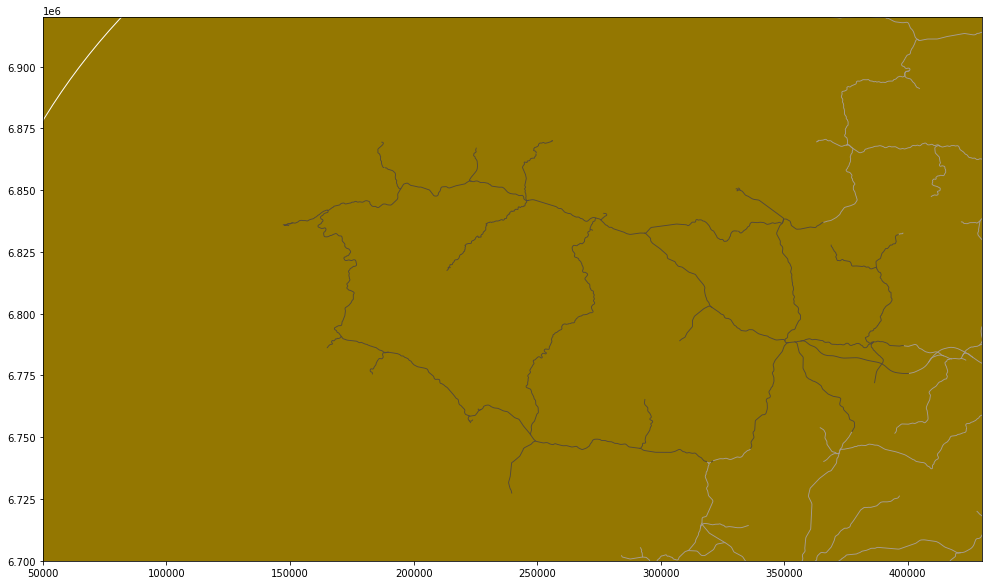

In [125]:
fig, ax = plt.subplots(figsize=(20,10))
ax.set_ylim(6700000,6920000)
ax.set_xlim(50000,430000)
ax.set_facecolor("#aec1d9")
dep_FR.plot(ax=ax, color="#c2c7c7", linewidth=.2,edgecolor="#c2c7c7")
rails_hbretagne.plot(ax=ax, color="#a69e94", linewidth=.9,edgecolor="#a69e94")
dep_bretagne.plot(ax=ax, color="#797c7c", linewidth=.25,edgecolor="#d6d6d6")
rails_bretagne.plot(ax=ax, color="#52483c", linewidth=.9,edgecolor="#52483c")
frequentation_bretagne.plot(ax=ax, marker='o', color="#947701", markersize="v2019",edgecolor="white");

D'énormes bulles, bien trop grosses pour être appréciées. Nous allons faire au plus simple, en créant sur la GDF frequentation_bretagne une nouvelle colonne où **chaque valeur de v2019 sera divisée par un même dénominateur**. Le rapport de proportion entre les différentes fréquentations sera ainsi conservé.

Vérifions que cela fonctionne en considérant pour la taille des marqueurs cette nouvelle colonne :

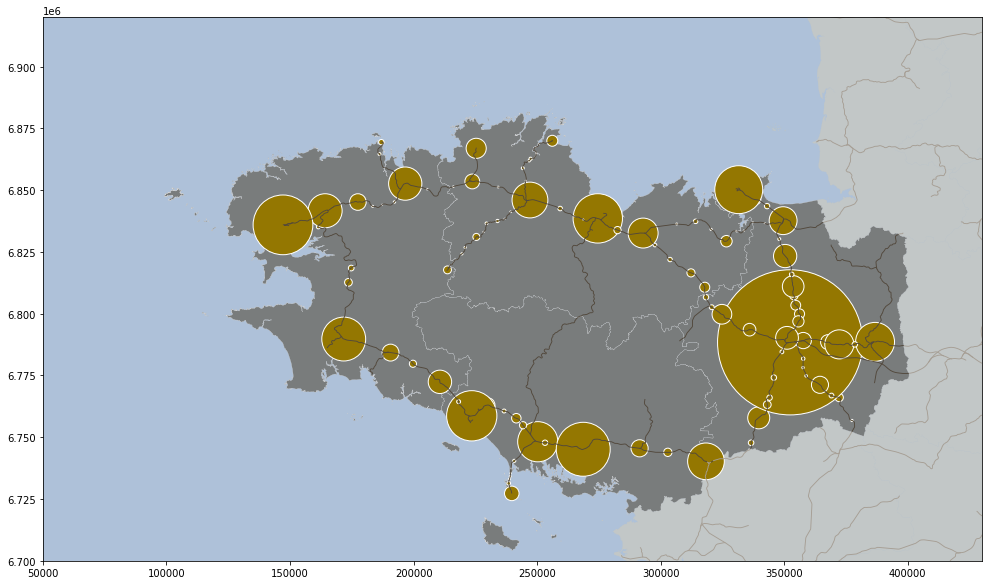

In [27]:
frequentation_bretagne["r_infog"]=frequentation_bretagne["v2019"]/550

fig, ax = plt.subplots(figsize=(20,10))
ax.set_ylim(6700000,6920000)
ax.set_xlim(50000,430000)
ax.set_facecolor("#aec1d9")
dep_FR.plot(ax=ax, color="#c2c7c7", linewidth=.2,edgecolor="#c2c7c7")
rails_hbretagne.plot(ax=ax, color="#a69e94", linewidth=.9,edgecolor="#a69e94")
dep_bretagne.plot(ax=ax, color="#797c7c", linewidth=.25,edgecolor="#d6d6d6")
rails_bretagne.plot(ax=ax, color="#52483c", linewidth=.9,edgecolor="#52483c")
frequentation_bretagne.plot(ax=ax, marker='o', color="#947701", markersize="r_infog",edgecolor="white");

C'est pas mal, mais **certaines bulles plus petites sont cachées par d'autres**. Une méthode très simple consiste à trier la GDF dans l'ordre décroissant. Ainsi, les gares les plus fréquentées apparaîtront toujours sous les autres.

La [fonction de pandas sort_values]() marche également sur les GDF, la preuve tout de suite :

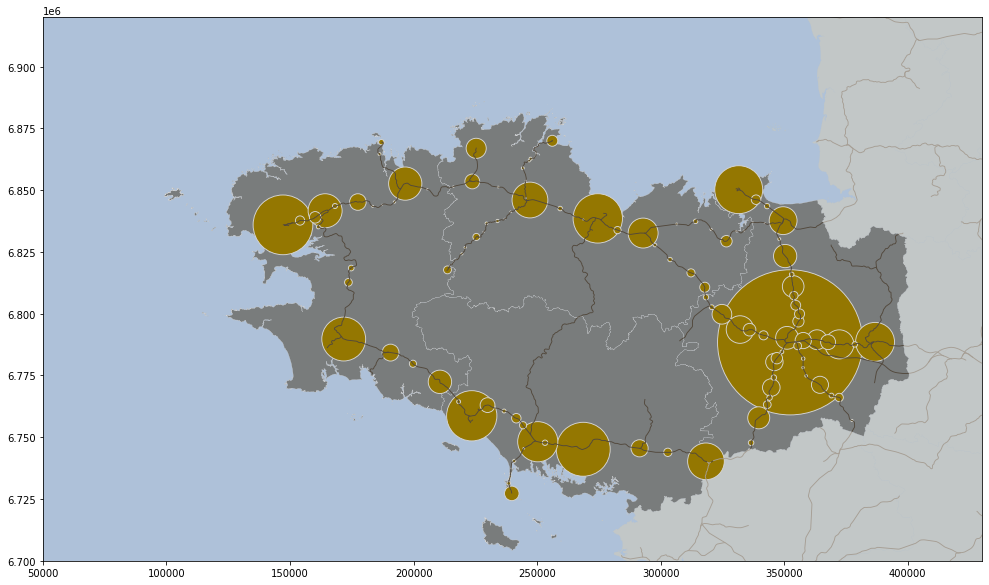

In [28]:
frequentation_bretagne.sort_values(by=["v2019"],ascending=False,inplace=True)

fig, ax = plt.subplots(figsize=(20,10))
ax.set_ylim(6700000,6920000)
ax.set_xlim(50000,430000)
ax.set_facecolor("#aec1d9")
dep_FR.plot(ax=ax, color="#c2c7c7", linewidth=.2,edgecolor="#c2c7c7")
rails_hbretagne.plot(ax=ax, color="#a69e94", linewidth=.9,edgecolor="#a69e94")
dep_bretagne.plot(ax=ax, color="#797c7c", linewidth=.25,edgecolor="#d6d6d6")
rails_bretagne.plot(ax=ax, color="#52483c", linewidth=.9,edgecolor="#52483c")
frequentation_bretagne.plot(ax=ax, marker='o', color="#947701", markersize="r_infog",linewidth=.9, edgecolor="#d6d6d6");

Mieux, mais nous pouvons encore améliorer le rendu en appliquant **un ordre d'apparition aux calques**. Cela se fait de façon intuitive **grâce au paramètre zorder** : un zorder à 0 sera en-dessous du 1, qui sera en-dessous d'un zorder de 2, etc :

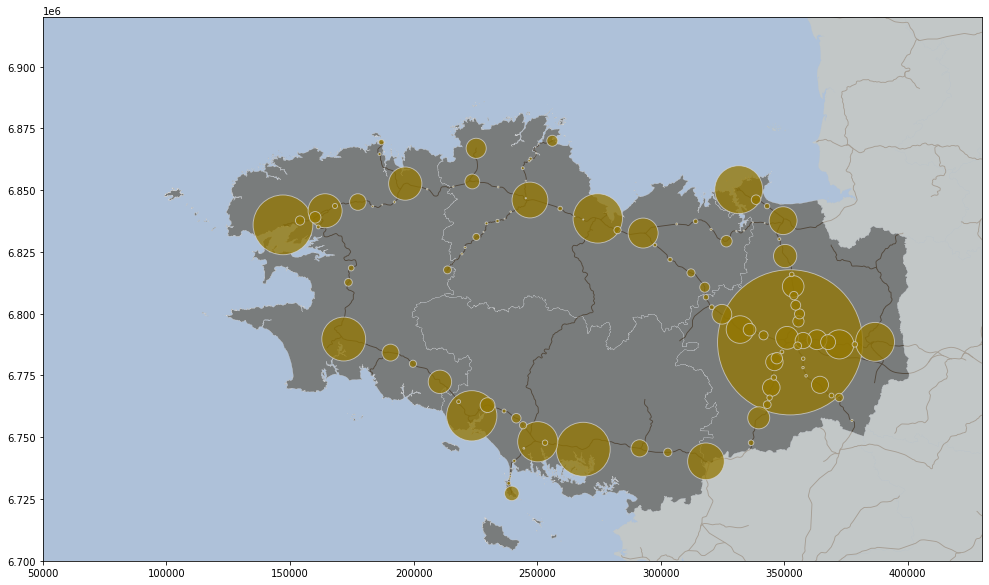

In [29]:
fig, ax = plt.subplots(figsize=(20,10))
ax.set_ylim(6700000,6920000)
ax.set_xlim(50000,430000)
ax.set_facecolor("#aec1d9")
dep_FR.plot(ax=ax, color="#c2c7c7", linewidth=.2,edgecolor="#c2c7c7", zorder=0)
rails_hbretagne.plot(ax=ax, color="#a69e94", linewidth=.9,edgecolor="#a69e94", zorder=1)
dep_bretagne.plot(ax=ax, color="#797c7c", linewidth=.25,edgecolor="#d6d6d6", zorder=0)
rails_bretagne.plot(ax=ax, color="#52483c", linewidth=.9,edgecolor="#52483c", zorder=1)
frequentation_bretagne.plot(ax=ax, marker='o', color="#947701", markersize="r_infog",linewidth=.9, edgecolor="#d6d6d6", alpha=.75, zorder=2);

Cette carte est pas mal du tout. Mais le diable est dans les détails, et nous allons nous pencher dessus :

# Légende et peaufinages divers

On va ajouter une légende à notre carte afin d'avoir une vague idée des ordres de grandeur présentés sur la carte. D'abord, regardons les premières valeurs de frequentation_bretagne :

In [30]:
frequentation_bretagne.iloc[:10]["v2019"]

47     11588429
110     1962604
129     1599913
37      1390474
19      1340194
128     1263626
125     1058048
56       887927
83       831668
16       740222
Name: v2019, dtype: int64

On passe de 11 millions à environ 2 millions pour la seconde valeur. Ces deux références seraient déjà un sacré plus. Comment faire ? Une méthode acceptable consiste à créer de zéro une nouvelle GeoDataFrame. On utilisera notamment une colonne r_infog qui divisera les valeurs décrites par 550, le dénominateur utilisé précédemment :

In [31]:
legende=gpd.GeoDataFrame({"nom":["10M","2M"],"r_infog":[10000000/550,2000000/550],"geometry":[Point(85500, 6745000),Point(85500, 6745000)]},crs="EPSG:2154")
legende

,nom,r_infog,geometry
0,10M,18181.818182,POINT (85500.000 6745000.000)
1,2M,3636.363636,POINT (85500.000 6745000.000)


Il y a beaucoup d'essais, notamment sur la bonne position des points de légende, mais nous pouvons assez facilement personnaliser la carte **en ajoutant aussi quelques annotations**. La fonction text appelée prend notamment en considération :

* les cordonnées x/y brut, 0 pour l'origine, 1 pour l'autre bord
* un texte
* une couleur
* une taille de police

Cela donne, avec notre nouvelle GeoDataFrame :

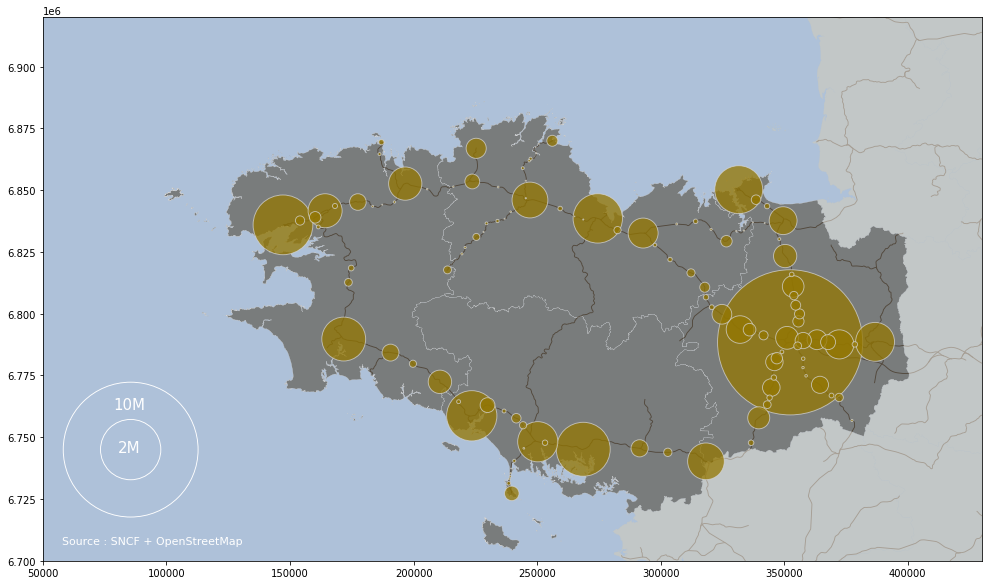

In [32]:
fig, ax = plt.subplots(figsize=(20,10))
ax.set_ylim(6700000,6920000)
ax.set_xlim(50000,430000)
ax.set_facecolor("#aec1d9")
dep_FR.plot(ax=ax, color="#c2c7c7", linewidth=.2,edgecolor="#c2c7c7", zorder=0)
rails_hbretagne.plot(ax=ax, color="#a69e94", linewidth=.9,edgecolor="#a69e94", zorder=1)
dep_bretagne.plot(ax=ax, color="#797c7c", linewidth=.25,edgecolor="#d6d6d6", zorder=0)
rails_bretagne.plot(ax=ax, color="#52483c", linewidth=.9,edgecolor="#52483c", zorder=1)
frequentation_bretagne.plot(ax=ax, marker='o', color="#947701", markersize="r_infog",linewidth=.9, edgecolor="#d6d6d6", alpha=.75, zorder=2)
legende.plot(ax=ax, marker='o', facecolor="none", markersize="r_infog",linewidth=.9, edgecolor="#fff", zorder=0)
ax.text(0.075, 0.28, "10M",  transform=ax.transAxes, color="#fff", fontsize=15)
ax.text(0.08, 0.2, "2M",  transform=ax.transAxes, color="#fff", fontsize=15)
ax.text(0.02, 0.03, "Source : SNCF + OpenStreetMap",  transform=ax.transAxes, color="#fff", fontsize=11);

On peut encore embellir les choses **en :

* modifiant la police de caractère** pour l'élégante Garamond 
* ajoutant le nom des étendues d'eau
* rectifiant un tout petit le cadre sur la Bretagne seule

L'ensemble est assez solide pour être ensuite enregistré en fichier jpg :

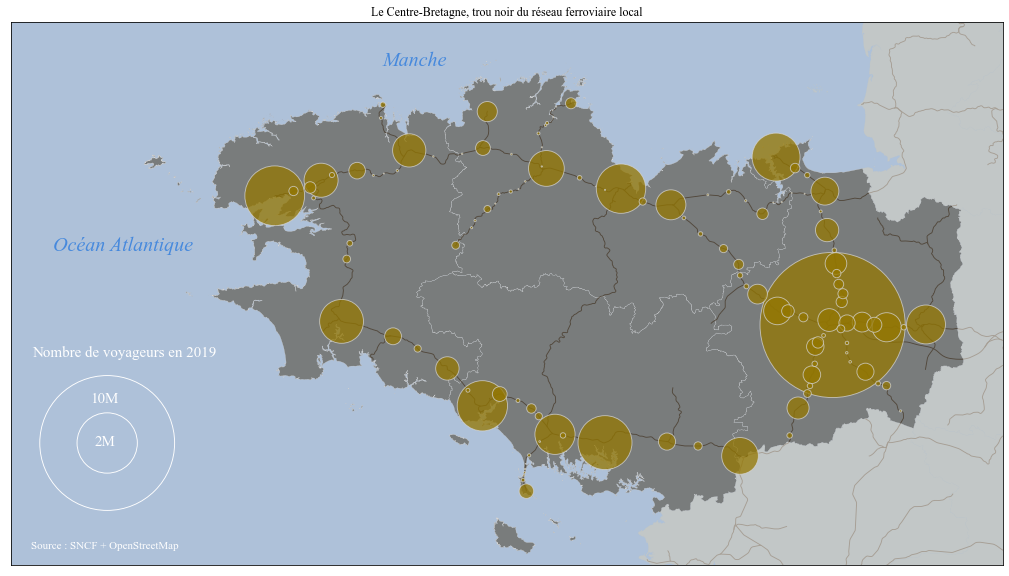

In [33]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams['mathtext.default']

fig, ax = plt.subplots(figsize=(20,10))
ax.set_ylim(6700000,6900000)
ax.set_xlim(50000,415000)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_facecolor("#aec1d9")
ax.text(0.022, 0.385, "Nombre de voyageurs en 2019",  transform=ax.transAxes, color="#fff", fontsize=15)
ax.text(0.08, 0.3, "10M",  transform=ax.transAxes, color="#fff", fontsize=15)
ax.text(0.085, 0.22, "2M",  transform=ax.transAxes, color="#fff", fontsize=15)
ax.text(0.02, 0.03, "Source : SNCF + OpenStreetMap",  transform=ax.transAxes, color="#fff", fontsize=11)
ax.text(0.043, 0.58, "Océan Atlantique", style='italic', transform=ax.transAxes, color="#4689dd", fontsize=20)
ax.text(0.375, 0.92, "Manche", style='italic', transform=ax.transAxes, color="#4689dd", fontsize=20)
dep_FR.plot(ax=ax, color="#c2c7c7", linewidth=.2,edgecolor="#c2c7c7", zorder=0)
ax.set(title="Le Centre-Bretagne, trou noir du réseau ferroviaire local")
rails_hbretagne.plot(ax=ax, color="#a69e94", linewidth=.9,edgecolor="#a69e94", zorder=1)
dep_bretagne.plot(ax=ax, color="#797c7c", linewidth=.25,edgecolor="#d6d6d6", zorder=0)
rails_bretagne.plot(ax=ax, color="#52483c", linewidth=.9,edgecolor="#52483c", zorder=1)
frequentation_bretagne.plot(ax=ax, marker='o', color="#947701", markersize="r_infog",linewidth=.9, edgecolor="#d6d6d6", alpha=.75, zorder=2)
legende.plot(ax=ax, marker='o', facecolor="none", markersize="r_infog",linewidth=.9, edgecolor="#fff", zorder=0)
plt.savefig('bzh_ter2019.jpg', dpi=300, bbox_inches = 'tight')
plt.show();